In [ ]:
import numpy as np
from point_history import getmes
import pickle
import datetime
from get_point_map import get
from get_point_history import pget
from netCDF4 import Dataset
import pandas as pd

In [ ]:
import pytides
import copy

In [217]:
from bilinear import bilinear_interpolation

In [ ]:
%matplotlib notebook

In [ ]:
path='../../../tide_test/'

In [ ]:
basename='med'

In [ ]:
with open(path+basename+'.pkl', 'r') as f:
    ptr=pickle.load(f)

In [ ]:
ptr

In [ ]:
len(ptr)

In [ ]:
t1='20160101.00'

In [ ]:
t2='20160120.00'

In [ ]:
sdate=datetime.datetime.strptime(t1,'%Y%m%d.%H')

In [ ]:
edate=datetime.datetime.strptime(t2,'%Y%m%d.%H')

In [ ]:
hdata=Dataset(path+'trih-med.nc')

In [ ]:
hdata.variables.keys()

In [ ]:
hdata.variables['XSTAT']

In [ ]:
hdata.variables['ZWL'][:][:,0]


In [ ]:
import urllib2, urllib

In [ ]:
def getmes(sdate,edate,point):

    pdate=min([edate+datetime.timedelta(hours=72),datetime.datetime.now()])

    print sdate, edate
    url='http://webcritech.jrc.ec.europa.eu/SeaLevelsDb/Home/ShowBuoyData?id={}&dateMin=%2F{:02d}%2F{:02d}%2F{}+{:02d}%3A{:02d}&dateMax=%2F{:02d}%2F{:02d}%2F{}+{:02d}%3A{:02d}&field=&options='\
                                 .format(point,sdate.month,sdate.day,sdate.year,sdate.hour,0,pdate.month,pdate.day,pdate.year,pdate.hour,0)
    url='http://webcritech.jrc.ec.europa.eu/SeaLevelsDb/Home/ShowBuoyData?id={}&dateMin={}%2F{:02d}%2F{:02d}+{:02d}%3A{:02d}&dateMax={}%2F{:02d}%2F{:02d}+{:02d}%3A{:02d}&field=&options=precision=0'\
                                 .format(point,sdate.year,sdate.month,sdate.day,sdate.hour,0,pdate.year,pdate.month,pdate.day,pdate.hour,0)
   
    print url
    response=urllib2.urlopen(url)
    ls=response.readlines()
    lp=[elem.strip().split(',')  for elem in ls]

  # get lat lon
    c=[a.split(' ') for a in lp[1]][0]
    if 'lat=' in c[2]:
            plat=c[2].split('=')[1]
            idt=6
    else:
            c=[a.split(' ') for a in lp[2]][0]
            if 'lat=' in c[2]: plat=c[2].split('=')[1]
            idt=7

    if 'lon=' in c[3]: plon=c[3].split('=')[1]

    rt=[]
    vt=[]
    for a,b,c,d in lp[idt:]:
        rt.append(datetime.datetime.strptime(a,'%d %b %Y %H:%M:%S'))
        vt.append([b,c,d])

    return rt,vt,plat,plon



In [ ]:
from grid import *
from dep import *

In [ ]:
def get(t0,t1,path,basename,plat,plon):

    plat=float(plat)
    plon=float(plon)

# print plon,plat
    tstart=datetime.datetime.strptime(t0,'%Y%m%d.%H')
    tend=datetime.datetime.strptime(t1,'%Y%m%d.%H')

    grid = Grid.fromfile(path+basename+'.grd')
    lon=grid.x[0,:].data
    lat=grid.y[:,0].data
    bath=Dep.read(path+basename+'.dep',grid.shape)
    bath.val=bath.val.T[:-1,:-1]
    dx=lon[1]-lon[0]
    dy=lat[1]-lat[0]
    x=lon
    y=lat


    i=np.abs(x-plon).argmin()
    j=np.abs(y-plat).argmin()
    x0=grid.x.T[i,j]
    y0=grid.y.T[i,j]
# print i,j,x0,y0,bath.val[i,j]
  # retrieve the 4 nearest diagonal points of the i,j
    lon4=grid.x.T[i-1:i+2:2,j-1:j+2:2]
    lat4=grid.y.T[i-1:i+2:2,j-1:j+2:2]
    val4=bath.val[i-1:i+2:2,j-1:j+2:2]
# print zip(lon4.flatten(),lat4.flatten(),val4.flatten())
# print '==================='
    lon8=grid.x.T[i-1:i+2,j-1:j+2]
    lat8=grid.y.T[i-1:i+2,j-1:j+2]
    val8=bath.val[i-1:i+2,j-1:j+2]
# print zip(lon8.flatten(),lat8.flatten(),val8.flatten())
# print '==================='
  # define the quandrant
    A=plon-x0
    B=plat-y0
    for xx,yy in zip(lon4.flatten(),lat4.flatten()):
#        print xx,yy
         C=np.sign([xx-plon,A])
         D=np.sign([yy-plat,B])
         if C[0]==C[-1] and D[0] == D[-1] :
            corner=[xx,yy]
            indx=[np.abs(x-xx).argmin(),np.abs(y-yy).argmin()]

# print indx
# print [x0,y0,bath.val[i,j]]
# print [x0,corner[1],bath.val[i,indx[1]]]
# print [corner[0],corner[1],bath.val[indx[0],indx[1]]]
# print [corner[0],y0,bath.val[indx[0],j]]


    l=np.argwhere(np.array(val8)==np.nanmax(np.array(val8)))
    [ii,jj]=l.ravel()

    wx=lon8[ii,jj]
    wy=lat8[ii,jj]
    i=np.abs(x-wx).argmin()
    j=np.abs((y-wy).T).argmin()

    d = Dataset(path+'trim-'+basename+'.nc')
   #h=d.variables['S1'][:,i:i+2,j:j+2]
    h=d.variables['S1'][:,i,j]


    time=d.variables['time'][:]
    
    tstamp=[]
    for l in time : tstamp.append(tstart+datetime.timedelta(0,int(l)))

    return np.array(tstamp),h

In [ ]:
OFILE='/mnt/pandora/Projects_Critech/EX_2015_CoastAlRisk/maps/data/s_b_data.txt'

In [ ]:
obs=pd.read_csv(OFILE,delimiter='\t')

In [ ]:
obs['ID'].values

In [228]:
obs

,ID,NAME,latobs,lonobs,latcalc,loncalc
0,1630,Almeira,36.8300,-2.4800,36.72506,-2.468386
1,1706,Valencia,39.4400,-0.3100,39.44040,-0.299000
2,819,Barcelona,41.3400,2.1600,41.27749,2.213909
3,1461,Palma de Mallorca,39.5600,2.6380,39.39457,2.614552
4,1741,Sete,43.3976,3.6991,43.31857,3.761195
5,1500,Corsica,42.9670,9.3500,43.09528,9.267036
6,1841,Carloforte,39.1480,8.3095,39.22599,8.231240
7,1848,Imperia,43.8783,8.0189,43.83057,8.149480
8,1846,Genova,44.4101,8.9255,44.32259,8.919400
9,1843,Civitavecchia,42.0940,11.7896,41.99920,11.677270


In [ ]:
rt=[]
hs=[]
mt=[]
mh=[]
ht=[]
hh=[]
tota=[]
for n in obs['ID'].values:
    print n
    t,s,plat,plon = getmes(sdate,edate,n)
    rt.append(t)
    hs.append([b for [a,b,c] in s])
    dic0={'t_gauge':t, 's':[b for [a,b,c] in s]}
    data0=pd.DataFrame(dic0)
    data0=data0.set_index('t_gauge')
    tcw,cw=get(t1,t2,path,basename,plat,plon)
    mt.append(tcw)
    mh.append(cw)
    dic1={'t_map':tcw, 's_map':cw}
    data1=pd.DataFrame.from_dict(dic1)
    data1=data1.set_index('t_map')
    data=data0.join(data1, how='outer')
    hcw,hw=hdata.variables['time'][:][:], hdata.variables['ZWL'][:][:,ptr[n]]
    ht.append([sdate+datetime.timedelta(0,int(l)) for l in hcw])
    hh.append(hw)
    dic2={'t_his':[sdate+datetime.timedelta(0,int(l)) for l in hcw], 's_his':hw}
    data2=pd.DataFrame.from_dict(dic2)
    data2=data2.set_index('t_his')
    data=data.join(data2, how='outer')
    tota.append(data)

In [ ]:
#tota=pd.concat(tota, keys=ptr.keys()[:20])

In [ ]:
tota=pd.concat(tota, keys=obs['ID'].values)

In [ ]:
tota.head()

In [ ]:
#tota=pd.to_numeric(tota, errors='coerce')

In [ ]:
tota[['s','s_map','s_his']] = tota[['s','s_map','s_his']].apply(pd.to_numeric)

In [ ]:
#tota.unstack(level=0).plot()

In [ ]:
#ptr.keys()[10]

In [ ]:
#tota.xs(ptr.keys()[17]).head()

In [ ]:
#ax=tota.xs(ptr.keys()[10]).plot(style=['k-','go','r-'])

## READ the local tide coefficients 

In [ ]:
# med tide dataset
TPATH='../TIDES/'
dmed=Dataset(TPATH+'med.nc')

In [ ]:
tlat=dmed['lat'][:]
tlon=dmed['lon'][:]

In [ ]:
tidal_c=dmed['tidal_constituents'][:]

In [ ]:
tidal_c=[''.join(k).upper().strip() for k in tidal_c] #form name tags

In [ ]:
amp=dmed['tidal_amplitude_h']
ph=dmed['tidal_phase_h']

## compare delft3d run with foreseen solution

In [225]:
def ctide(lon,lat,plon,plat,i,j):
    x0,y0 = lon[i], lat[j]

    # retrieve the 4 nearest diagonal points of the i,j
    lon4=lon[i-1:i+2:2]
    lon4=np.vstack([lon4,lon4])
    lat4=lat[j-1:j+2:2]
    lat4=np.vstack([lat4,lat4]).T
# print '==================='
  # define the quandrant
    A=plon-x0
    B=plat-y0
    for xx,yy in zip(lon4.flatten(),lat4.flatten()):
#        print xx,yy
         C=np.sign([xx-plon,A])
         D=np.sign([yy-plat,B])
         if C[0]==C[-1] and D[0] == D[-1] :
            corner=[xx,yy]
            indx=[np.abs(lon-xx).argmin(),np.abs(lat-yy).argmin()]

    phv=np.zeros(ph.shape[-1])
    amv=np.zeros(amp.shape[-1])
    for k in range(amp.shape[-1]):

        p1=[x0,y0,amp[i,j,k]]
        p2=[x0,corner[1],amp[i,indx[1],k]]
        p3=[corner[0],corner[1],amp[indx[0],indx[1],k]]
        p4=[corner[0],y0,amp[indx[0],j,k]]

        points=[p1,p2,p3,p4]

        amv[k]= bilinear_interpolation(plon,plat,points)

        p1=[x0,y0,ph[i,j,k]]
        p2=[x0,corner[1],ph[i,indx[1],k]]
        p3=[corner[0],corner[1],ph[indx[0],indx[1],k]]
        p4=[corner[0],y0,ph[indx[0],j,k]]

        points=[p1,p2,p3,p4]

        phv[k]= bilinear_interpolation(plon,plat,points)

    return amv,phv

In [237]:
def compare(idx):
    ax=tota.xs(obs['ID'].values[idx])['s_his'].plot()#style=['k-','go','r-'])
    plon=obs['loncalc'][idx]
    plat=obs['latcalc'][idx]
    print plon,plat
    i=np.abs(tlon-np.float(plon)).argmin()
    j=np.abs(tlat-np.float(plat)).argmin()
    print i,j
    
#  tampl=amp[i,j,:]
#  tphase=ph[i,j,:]

    tampl,tphase=ctide(tlon,tlat,plon,plat,i,j)
    dd=np.array([tampl,tphase]).T

    df=pd.DataFrame(dd, columns=['amplitude','phase'], index=tidal_c)

## create a tide model from osbervation (like a template)
    demeaned=tota.xs(obs['ID'].values[idx])['s_his'].values-tota.xs(obs['ID'].values[idx])['s'].mean()

    tide=pytides.tide.Tide.decompose(demeaned, tota.xs(obs['ID'].values[idx])['s'].index)

# set a tide object to validate
    tomed=copy.deepcopy(tide)

    k=0
    for c,a,p in tomed.model:
        if c.name in df.index:
            tomed.model['amplitude'][k] = df['amplitude'][c.name]
            tomed.model['phase'][k] = df['phase'][c.name]
        else:
            tomed.model['amplitude'][k]=0.
            tomed.model['phase'][k]=0.
        k +=1    

    dates=pd.date_range(start='2016-01-01',end='2016-01-20',freq='6T')

    hours=np.cumsum(np.r_[0, [t.total_seconds()/3600.0 for t in np.diff(dates.to_pydatetime())]])

    times=pytides.tide.Tide._times(dates[0], hours)

    med_deltares = pd.Series(tomed.at(times) + tota.xs(obs['ID'].values[idx])['s_his'].mean(), index=dates)

    med_deltares.plot(ax=ax, color='green', linestyle='--', label='pytides from deltares med')

<IPython.core.display.Javascript object>


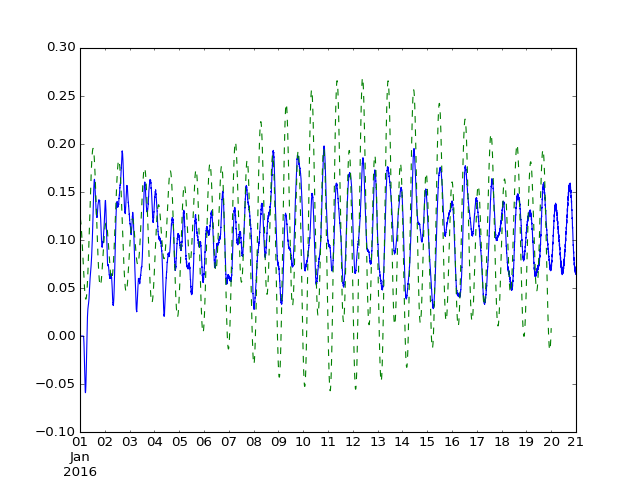

8.9194 44.32259
508 430


In [241]:
compare(8)

## MISC

In [ ]:
tota.unstack().xs(2561)

In [ ]:
#data=pd.to_numeric(data, errors='coerce')

In [ ]:
data[['s','s_map','s_his']] = data[['s','s_map','s_his']].apply(pd.to_numeric)

In [ ]:
data.plot(style=['k-','go','r-'])

In [ ]:
mh

In [ ]:
hh

In [ ]:
dic0={'t_gauge':rt[0], 's':hs[0], 't_hist':ht[0], 's_hist':hh[0], 't_map':mt[0], 's_map':mh[0]}

In [ ]:
data=pd.DataFrame.from_dict(dic0,orient='index')

In [ ]:
data[:5]

In [ ]:
data=data.transpose()

In [ ]:
data[:5]

In [ ]:
data=data.set_index(['t_gauge'])

In [ ]:
data['s'][:5]

In [ ]:
gauge=pd.Series(data['s'])

In [ ]:
gauge[:15]

In [ ]:
#gauge=gauge.rename(index=data['t_gauge'])

In [ ]:
gauge=pd.to_numeric(gauge)

In [ ]:
ax=gauge.plot()

In [ ]:
gauge1=pd.Series(data['s_map'])

In [ ]:
gauge1[:5]

In [ ]:
gauge1.plot(ax=ax)

In [ ]:
data['s']=pd.to_numeric(data['s'])

In [ ]:
#data.plot(x='t_gauge',y='s', style='k-')

In [ ]:
dic0={'t_gauge':rt[0], 's':hs[0]}

In [ ]:
data0=pd.DataFrame(dic0)

In [ ]:
data0=data0.set_index('t_gauge')

In [ ]:
data0[:5]

In [ ]:
dic1={'t_map':mt[0], 's_map':mh[0]}

In [ ]:
data1=pd.DataFrame.from_dict(dic1)

In [ ]:
data1=data1.set_index('t_map')

In [ ]:
data1[:5]

In [ ]:
dataf=data0.join(data1, how='outer')

In [ ]:
dataf[:5]

In [ ]:
dataf[['s','s_map']] = dataf[['s','s_map']].apply(pd.to_numeric)

In [ ]:
dataf.plot(style=['b-','ro'])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
dataf.index.to_pydatetime()

In [ ]:
dataf[:5]

In [ ]:
mask=np.isfinite(dataf['s_map'])

In [ ]:
dataf['s_map'][mask]

In [ ]:
plt.plot(dataf['s_map'][mask], '-o')

In [ ]:
dic1={'t_gauge':rt[1], 's':hs[1], 't_hist':ht[1], 's_hist':hh[1], 't_map':mt[1], 's_map':mh[1]}

In [ ]:
dataf

In [ ]:
pd.concat([dataf,dataf], keys=['0', '1'])